## Lab 2: TBD
In this lab we will discuss how we can leverage multiple accelerators in a single device to perform distributed operations. We will review previous concepts, re-contextualized with multiple GPUs.

### Pre-Requisite Knowledge
We highly suggestion you read up on [sharding concepts and collective communications](https://jax-ml.github.io/scaling-book/sharding/).

### In this Lab You Will:
- See the roofline model in the context of multiple accelerators
- Distribute your GEMM calculation across multiple accelerators
- Understand the tradeoffs as you parallelize with two standard HPC models
- (Optional) See a more detailed/conceptual breakdown of how matrices are sharded across GPUs


### Imports and GPU Information
Here we import the relevant libraries and retrieve detailed information about the available GPUs in our environment. We use pynvml to get low-level GPU metrics (e.g., name, memory size, clock speeds), and set up any necessary environment variables (like PyTorch memory allocations). This step helps us understand and confirm our hardware configuration.

In [6]:
# Step 1: Environment Setup
%pip install transformers torch pynvml matplotlib numpy scipy torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Step 2: Imports and GPU Information

import torch
import pynvml
import os

# Configure PyTorch memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

pynvml.nvmlInit()
num_gpus = pynvml.nvmlDeviceGetCount()
memory_bandwidth_tb_s = 0.3

print(f"Available GPUs: {num_gpus}")

gpu_info = {}
for i in range(num_gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    name = pynvml.nvmlDeviceGetName(handle)
    memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    mem_total_tb = memory_info.total / (1024 ** 3)
    clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
    mem_clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
    compute_capability = torch.cuda.get_device_capability(i)
    
    gpu_info[i] = {
        'name': name,
        'memory_tb': mem_total_tb,
        'gpu_clock_mhz': clock_info,
        'mem_clock_mhz': mem_clock_info,
        'memory_bandwidth_tb_s': memory_bandwidth_tb_s,
        'compute_capability': compute_capability
    }
    
    print(f"GPU {i}: {name}")
    print(f"  Memory: {mem_total_tb:.2f} GB")
    print(f"  GPU Clock: {clock_info} MHz")
    print(f"  Memory Clock: {mem_clock_info} MHz")
    print(f"  Approx. Memory Bandwidth: {memory_bandwidth_tb_s:.2f} TB/s")
    print(f"  Compute Capability: {compute_capability}")

pynvml.nvmlShutdown()
print("\nNote: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.")


Available GPUs: 4
GPU 0: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 1: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 2: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 3: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)

Note: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.


**This time we will use all 4 GPUs**

### In Practice
Now similar to last time, we will run the same operation on multiple GPUs. The only input change being the world_size or the number of accelerators available for our program.

In [8]:
import importlib
import utils.gemm_multigpu_benchmark as butils
importlib.reload(butils)

import torch.multiprocessing as mp
import json

# Define your custom test suite where world_size is number of GPUs
test_suites = [
    { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 512, "D": 4500, "F": 4500, "num_layers": 5, "weight_reuse_iters": 1}, 
        ]
    }, 
    { # 2 GPU
        "world_size": 2, 
        "tests": [
            {"batch_size": 512, "D": 4500, "F": 4500, "num_layers": 5, "weight_reuse_iters": 1}, 
        ]
    } , 
    { # 4 GPU
        "world_size": 4, 
        "tests": [
            {"batch_size": 512, "D": 4500, "F": 4500, "num_layers": 5, "weight_reuse_iters": 1}, 
        ]
    } 
]
results = []
for suite in test_suites:
    world_size, tests = suite["world_size"], suite["tests"]
    mp.spawn(butils.distributed_main, args=(world_size, tests), nprocs=world_size, join=True)
    with open(f"results/distributed_test_suite_results_{world_size}gpus.json", "r") as f:
         results.append(json.load(f))

print(json.dumps(results, indent=2))
    


Rank 0 running on GPU 0
PASSED: B=512, D=4500, F=4500, layers=5
  Local GFLOPs: 66470.83  |  Aggregated GFLOPs: 66470.83
  Total FLOPs: 1.04e+11  |  Estimated Memory: 2.49e+08
  Arithmetic Intensity: 417.089
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_1gpus.json
Rank 0 running on GPU 0
Rank 1 running on GPU 1
PASSED: B=512, D=4500, F=4500, layers=5
  Local GFLOPs: 66863.29  |  Aggregated GFLOPs: 134785.55
  Total FLOPs: 2.07e+11  |  Estimated Memory: 4.97e+08
  Arithmetic Intensity: 417.089
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_2gpus.json
Rank 2 running on GPU 2
Rank 1 running on GPU 1
Rank 0 running on GPU 0
Rank 3 running on GPU 3
PASSED: B=512, D=4500, F=4500, layers=5
  Local GFLOPs: 66711.48  |  Aggregated GFLOPs: 268742.97
  Total FLOPs: 4.15e+11  

### Construct Roofline Chart
Notice in the plot we can far exceed our *original* barrier (the orange line). But, similar to last time, we cannot hit the "theoretical" maximum for our roofline. Notice as well: once you've determined the arithmetic intensity for an algorithm, adding accelerators *does not* change this, and you simply see a direct performance boost (barring collectives).

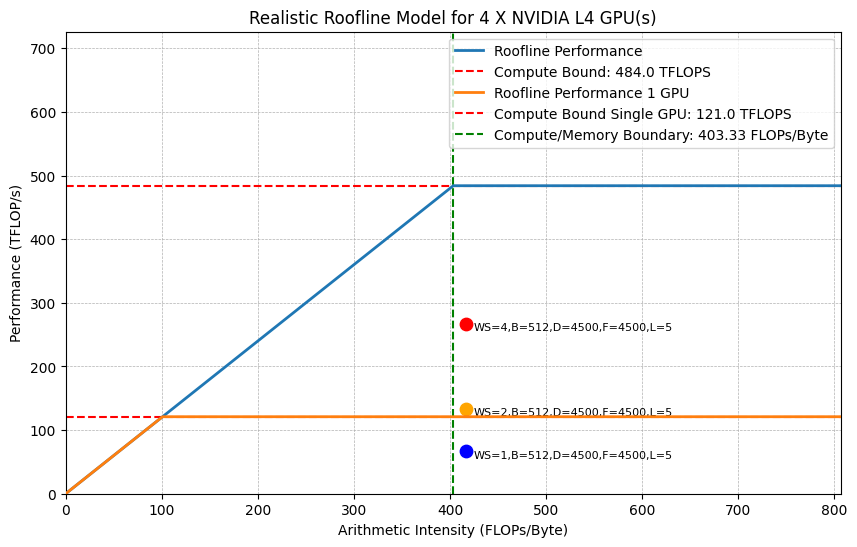

In [9]:
import importlib
import utils.plot_utils as putils
importlib.reload(putils)

# Now use it
putils.plot_roofline_chart(gpu_info, results)


### Scaling Laws
Given the complexity of distributed applications, there tends to be diminishing returns as you scale up. There are a few models you can use to predict the performance speed up you will see.

In this lab we will briefly cover (Amdhal's Law)[https://en.wikipedia.org/wiki/Amdahl%27s_law] and (Gustafson's Law)[https://en.wikipedia.org/wiki/Gustafson%27s_law]. This is purely an exercize for you to be cognicent of diminishintg returns of scaling up a parallel workload. 

#### In Practice
Below is a simple GEMM matmul with built in delays. Notice how there are diminishing improvements to the speed up of adding GPUs.

In [10]:
import importlib
import utils.gemm_basic_splitting as butils
importlib.reload(butils)

import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Run the experiments
N = 10000
A_cpu = torch.randn(N, N)
B_cpu = torch.randn(N, N)

# Track actual speedups
gpu_counts = list(range(1, 5))
actual_times = []
for gpu_count in gpu_counts:
    time_taken = butils.distributed_matmul(A_cpu, B_cpu, gpu_count)
    actual_times.append(time_taken)

1-GPU result sum: 1449640.12
1-GPU time: 0.35 seconds
2-GPU result sum: 1449640.12
2-GPU time: 0.30 seconds
3-GPU result sum: 1449639.75
3-GPU time: 0.24 seconds
4-GPU result sum: 1449640.12
4-GPU time: 0.22 seconds


Let’s see it in a graphic. Amdahl’s Law is a more pessimistic view, whereas Gustafson’s is optimistic. Essentially, assuming some portion of your program is serial (synchronous), you will see aggregated slowdowns as you scale up. Gustafson’s assumes you can gain proportional speedups. In this case, our workload is more similar to Amdahl’s model.

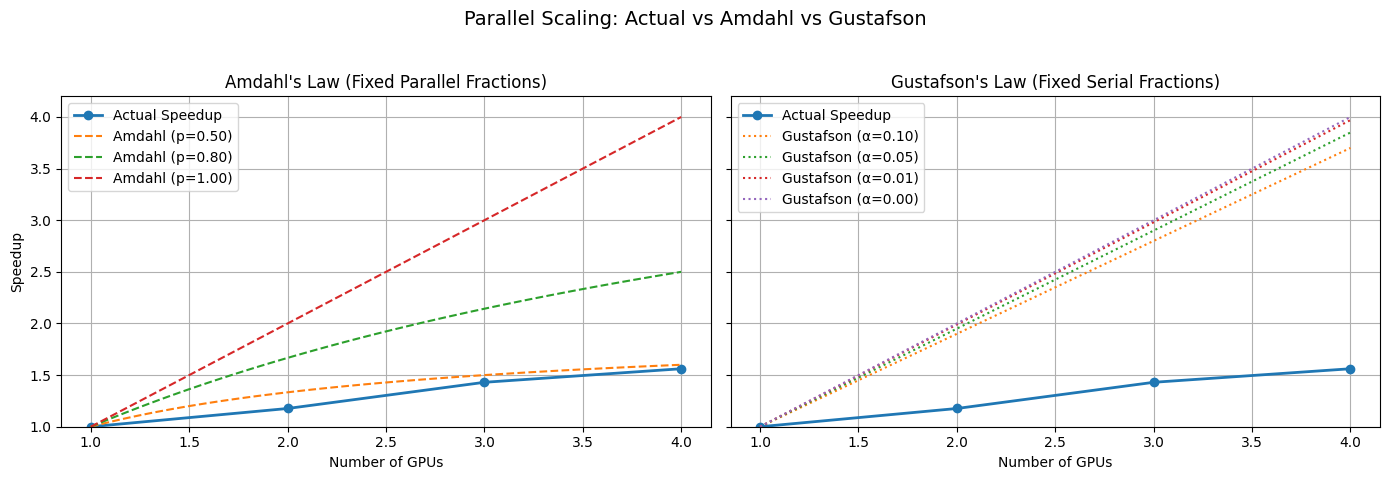

In [11]:
import utils.plot_utils as putils
importlib.reload(putils)


putils.plot_speedup_vs_theory(gpu_counts, actual_times)


## Distributed Frameworks

Now that you undersand generally the tradeoffs and considerations for distributed workloads. Let's use an existing framework, [PyTorch Distributed](https://pytorch.org/tutorials/beginner/dist_overview.html), and run a simple model across all GPUs. 

Typically, when distributing a workload with a framework, the script you write simply needs to know the world size, as well as what "rank" the code is running on (which accelerator it is). Using that information the script can easily determine which part of the operation it's responsible for. This becomes more complex when you want to employ different distribution strategies, but the core concept is the same. Using context, the model can select it's portion of the model weights, data, pipeline, etc.

For example:

If I want to add these two arrays: [1, 2, 3, 4, 5, 6, 7, 8] and [9, 10, 11, 12, 13, 14, 15, 16]. If I have 4 GPUs, each GPU just needs to know the size of the world (4) and it's rank to determinw what portion of the workload it's responsible for.

Rank0: This code knows it's rank 0, the world size is 4, and the array size is 4, so it will take 1/4th (2 values in the array) of the work. This rank will start at it's rank * it's portion of work (or the batch_size) as the starting point, until it's completed it's portion of work at the second value of the array. This would return [10, 12] for it's portion of the work.

Rank1: Similaly here, 1 (world size) * 2 (batch size) = 2 as the index to start at, and operate on two values at index 2 and 3 resulting in [14, 16]

Try to solve what the last two ranks would operate on, and what their results would be.

## In Practice
We'll be using pytorch distributed, and operating on random tensors to simulate work being split across the GPUs. In this case we won't be communicating across GPUs, so we will have the ideal parallel use case, 100% parallizable code. Read through [torch_distrubted.py](./utils/torch_distributed.py) if you'd like to see how it's being done.

In [12]:
import importlib
import utils.torch_distributed as dutils
importlib.reload(dutils)

import torch.multiprocessing as mp
import json

test_suites = [
    {"world_size": 1, "tests": [{"batch_size": 256, "num_batches": 20}]},
    {"world_size": 2, "tests": [{"batch_size": 256, "num_batches": 20}]},
    {"world_size": 3, "tests": [{"batch_size": 255, "num_batches": 20}]},
    {"world_size": 4, "tests": [{"batch_size": 256, "num_batches": 20}]}
]

results = []
for suite in test_suites:
    world_size, tests = suite["world_size"], suite["tests"]
    mp.spawn(dutils.distributed_resnet_inference, args=(world_size, tests), nprocs=world_size, join=True)
    with open(f"results/distributed_resnet_results_{world_size}gpus.json", "r") as f:
        results.append(json.load(f))

# Print or plot results
from pprint import pprint
pprint(results)


✅ PASSED: 1 GPU(s) | Batch 256 x 20
   Inference Time: 7.87 sec
------------------------------------------------------------
Results saved to results/distributed_resnet_results_1gpus.json
✅ PASSED: 2 GPU(s) | Batch 256 x 20
   Inference Time: 3.92 sec
------------------------------------------------------------
Results saved to results/distributed_resnet_results_2gpus.json
✅ PASSED: 3 GPU(s) | Batch 255 x 20
   Inference Time: 2.55 sec
------------------------------------------------------------
Results saved to results/distributed_resnet_results_3gpus.json
✅ PASSED: 4 GPU(s) | Batch 256 x 20
   Inference Time: 1.94 sec
------------------------------------------------------------
Results saved to results/distributed_resnet_results_4gpus.json
[[{'avg_time_seconds': 7.8704,
   'batch_size_per_gpu': 256,
   'batch_size_total': 256,
   'num_batches': 20,
   'world_size': 1}],
 [{'avg_time_seconds': 3.9169,
   'batch_size_per_gpu': 128,
   'batch_size_total': 256,
   'num_batches': 20,
   '

### Results

Run the code below to see how performance works in an ideal scenario. As you'll see, we *outperform* our theoretical max. Balancing these two models, and understanding what portion of your code is actually parallelizable is key to utilizing distributed compute effectively.

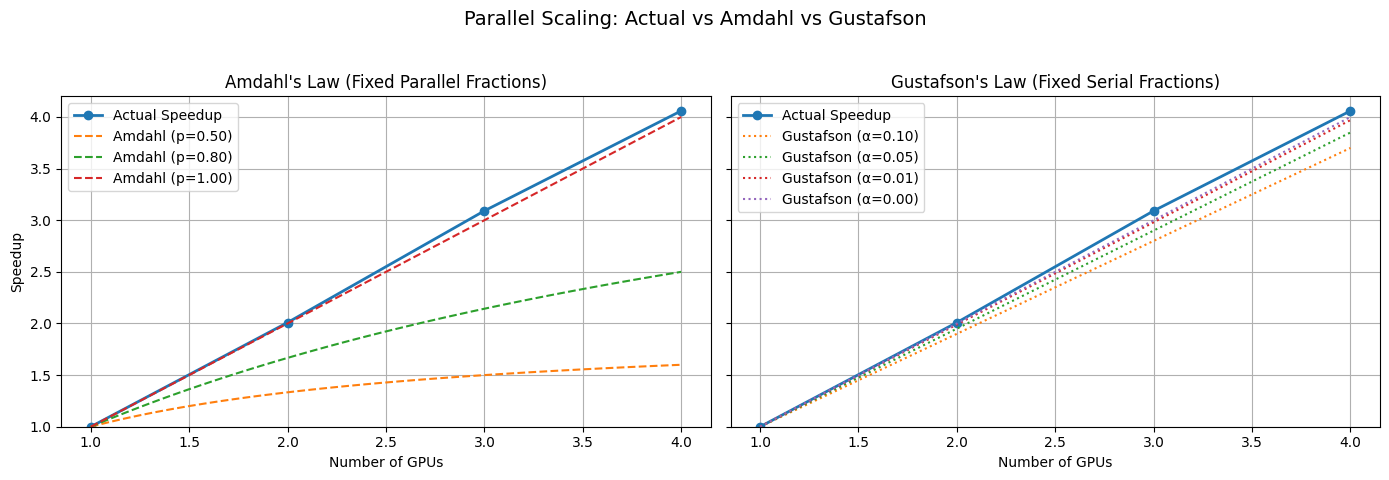

In [13]:
from utils.plot_utils import plot_speedup_vs_theory

gpu_counts = [1, 2, 3, 4]
actual_times = [res[0]["avg_time_seconds"] for res in results]

plot_speedup_vs_theory(gpu_counts, actual_times)
